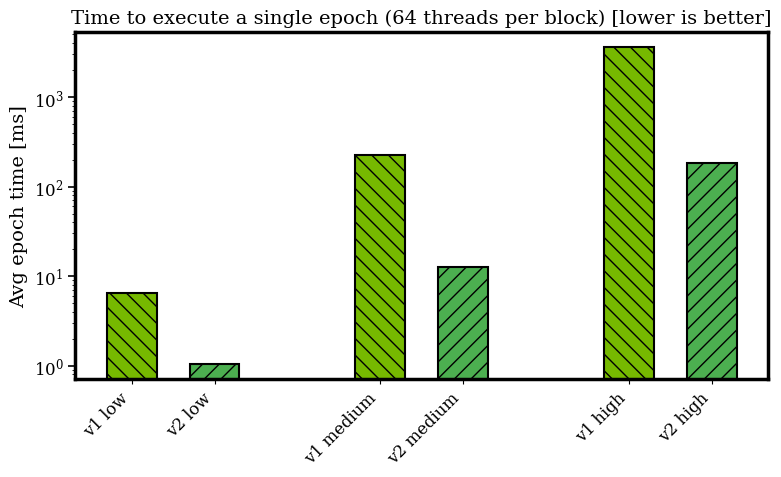

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Istogramma (scala log) dei tempi medi: barre raggruppate per versione,
con etichette leggibili e scala logaritmica.
"""

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ╔════════════════════════ PARAMETRI ═══════════════════════╗
THREADS_PER_BLOCK = 64
N_VERSIONI        = 2
FILE_PATH         = "time.txt"
BAR_WIDTH         = 0.6
GROUP_GAP         = 1.0
PARTICLE_LABELS   = {2000: "low", 16000: "medium", 60000: "high"}
# ╚══════════════════════════════════════════════════════════╝

# ─────────────── Lettura file ───────────────
rows = []
pattern = re.compile(r"(\d+)\s+(\d+)\s+(\d+)\s+(\d+):\s+([\d.]+)ms")

with Path(FILE_PATH).open() as f:
    for line in f:
        m = pattern.match(line.strip())
        if m:
            vers, tpb, part, it, t = m.groups()
            rows.append({
                "version"        : int(vers),
                "threadsPerBlock": int(tpb),
                "particles"      : int(part),
                "iteration"      : int(it),
                "time_ms"        : float(t)
            })

df = pd.DataFrame(rows)

# ─────────────── Filtro ───────────────
df = df[df["threadsPerBlock"] == THREADS_PER_BLOCK]

# ─────────────── Media tempi ───────────────
media = df.groupby(["particles", "version"])["time_ms"].mean().reset_index()

# ─────────────── Preparazione dati ───────────────
particles_sorted = sorted(media["particles"].unique())
values, x_labels, x_pos = [], [], []

for g_idx, p in enumerate(particles_sorted):
    label_base = PARTICLE_LABELS.get(p, str(p))
    base = g_idx * (N_VERSIONI + GROUP_GAP)
    for v_idx in range(N_VERSIONI):
        mask = (media["particles"] == p) & (media["version"] == v_idx)
        if mask.any():
            val = media.loc[mask, "time_ms"].iat[0]
            values.append(val)
            x_labels.append(f"v{v_idx+1} {label_base}")
            x_pos.append(base + v_idx)

# ─────────────── Stile ───────────────
rcParams.update({
    "font.family": "Serif",
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# ─────────────── Colori & Hatch ───────────────
base_colors = [
    "#76B900", "#4CAF50", "#2E7D32", "#2196F3", "#1976D2",
    "#F9A825", "#F44336", "#9C27B0", "#FF9800", "#009688"
]

base_hatch = [
    "\\\\", "//", "xx", "||", "oo", "--", "++", "..", "**", "OO"
]

base_colors = base_colors[:N_VERSIONI]
base_hatch  = base_hatch[:N_VERSIONI]

colors  = (base_colors * ((len(values) // len(base_colors)) + 1))[:len(values)]
hatches = (base_hatch  * ((len(values) // len(base_hatch )) + 1))[:len(values)]

# ─────────────── Plot ───────────────
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_yscale("log")

for i, (x, val) in enumerate(zip(x_pos, values)):
    ax.bar(x, val,
           width=BAR_WIDTH,
           color=colors[i],
           hatch=hatches[i],
           edgecolor="black",
           linewidth=1.5)

ax.set_ylabel("Avg epoch time [ms]")
ax.set_title(f"Time to execute a single epoch ({THREADS_PER_BLOCK} threads per block) [lower is better]")

# Etichette composite vN + livello (es. v1\nlow)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Bordi
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2.5)
    spine.set_edgecolor("black")

ax.tick_params(axis='y', length=5, width=1.2, color='black')
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("chart.svg", format="svg")
plt.show()


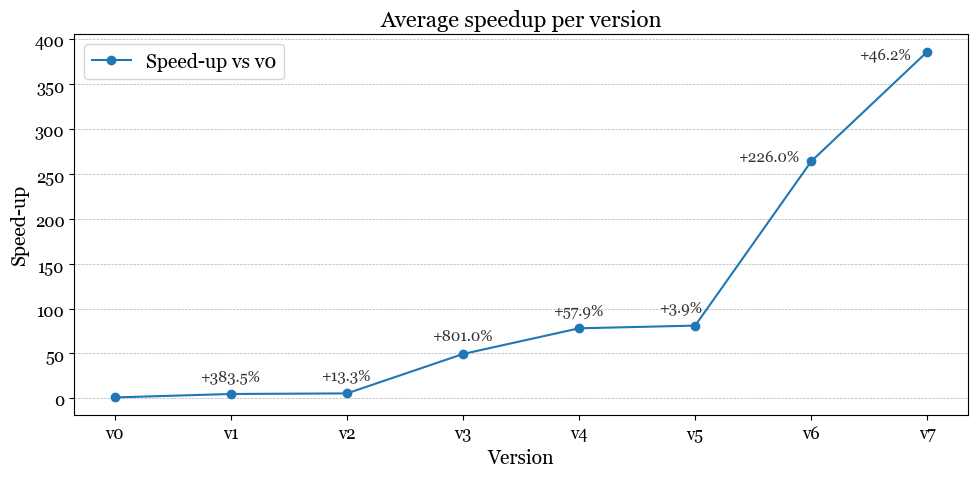

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Speed-up plot: un’unica curva (speed-up vs v0) con l’indicazione
del miglioramento percentuale rispetto alla versione precedente.
Salva il risultato in speedup_plot.pdf.
"""

import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ╔════════════════════════ PARAMETRI ═══════════════════════╗
FILE_PATH         = "speedup.txt"
PDF_NAME          = "speedup_plot.pdf"
EXPECTED_VERSIONS = 8          # v0 … v6
# ╚══════════════════════════════════════════════════════════╝

# Regex tollerante:  <versione> … : <tempo> [ms]
pattern = re.compile(
    r"""^\s*
        (\d+)            # versione
        .*?:\s*          # ':' eventuali spazi
        (\d+(?:\.\d+)?)  # valore tempo
        \s*(ms)?         # 'ms' opzionale
        \s*$""",
    re.VERBOSE)

# ─────────────── Parsing file ───────────────
data = {}
for line in Path(FILE_PATH).read_text().splitlines():
    m = pattern.match(line)
    if not m:
        continue
    v, val, is_ms = int(m.group(1)), float(m.group(2)), bool(m.group(3))
    time_ms = val if is_ms else val * 1000.0
    data.setdefault(v, []).append(time_ms)

versions = sorted(data.keys())
assert len(versions) == EXPECTED_VERSIONS, (
    f"Attese {EXPECTED_VERSIONS} versioni, trovate {len(versions)}: {versions}"
)

mean_times = [np.mean(data[v]) for v in versions]

# Speed-up vs baseline v0
baseline    = mean_times[0]
speed_vs_0  = [baseline / t for t in mean_times]

# Δ% rispetto alla versione precedente
delta_pct = [0.0] + [
    (mean_times[i-1] / mean_times[i] - 1.0) * 100.0
    for i in range(1, len(mean_times))
]

# ─────────────── Plot ───────────────
rcParams.update({
    "font.family"   : "Georgia",
    "font.size"     : 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

x = np.arange(len(versions))
fig, ax = plt.subplots(figsize=(10, 5))

# Unica linea
ax.plot(x, speed_vs_0, marker='o', linestyle='-', color='#1f77b4',
        label='Speed-up vs v0')

# Annotazioni “+x.x%” (salta v0)
for i in range(1, len(x)):
    if i >= 5:
        break
    ax.annotate(f"+{delta_pct[i]:.1f}%", (x[i], speed_vs_0[i]),
                textcoords="offset points", xytext=(0, 10),
                ha='center', fontsize=11, color="#333333")
    
ax.annotate(f"+{delta_pct[5]:.1f}%", (x[5], speed_vs_0[5]),
                textcoords="offset points", xytext=(-10, 10),
                ha='center', fontsize=11, color="#333333")

ax.annotate(f"+{delta_pct[6]:.1f}%", (x[6], speed_vs_0[6]),
                textcoords="offset points", xytext=(-30, 0),
                ha='center', fontsize=11, color="#333333")

ax.annotate(f"+{delta_pct[7]:.1f}%", (x[7], speed_vs_0[7]),
                textcoords="offset points", xytext=(-30, -5),
                ha='center', fontsize=11, color="#333333")

# Layout
ax.set_xlabel("Version")
ax.set_ylabel("Speed-up")
ax.set_title("Average speedup per version")
ax.set_xticks(x)
ax.set_xticklabels([f"v{v}" for v in versions])
ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("speedup.svg", format="svg")
plt.show()
